In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("data.csv", encoding='latin1')
print(df.head())

  stn_code       sampling_date           state   location agency  \
0    150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1    151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2    152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3    150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4    151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1                         NaN    NaN  1990-02-01  
2                         NaN    NaN  1990-02-01  
3       

/tmp/ipython-input-2614234962.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding='latin1')


In [5]:
x = df["no2"].dropna().values
print("Number of samples:", len(x))

Number of samples: 419509


In [7]:
r = 102303139
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r =", a_r)
print("b_r =", b_r)

a_r = 0.5
b_r = 1.5


In [9]:
z = x + a_r * np.sin(b_r * x)

print("Transformed variable 'z' shape:", z.shape)

Transformed variable 'z' shape: (419509,)


In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
z_scaled = scaler.fit_transform(z.reshape(-1,1))

real_data = torch.tensor(z_scaled, dtype=torch.float32)

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [20]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [24]:
# Remove top 1% extreme values
threshold = np.percentile(z, 99)
z = z[z <= threshold]

print("New max:", np.max(z))
print("New size:", len(z))

New max: 93.9504132604411
New size: 415320


In [25]:
z = np.log1p(z)   # log(1+z)

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
z_scaled = scaler.fit_transform(z.reshape(-1,1))

real_data = torch.tensor(z_scaled, dtype=torch.float32)

In [27]:
epochs = 5000
batch_size = 256

for epoch in range(epochs):

    idx = np.random.randint(0, real_data.size(0), batch_size)
    real_batch = real_data[idx]

    # Label smoothing
    real_labels = torch.ones(batch_size, 1) * 0.9
    fake_labels = torch.zeros(batch_size, 1)

    # Train Discriminator
    noise = torch.randn(batch_size, 1)
    fake_data = G(noise)

    loss_real = criterion(D(real_batch), real_labels)
    loss_fake = criterion(D(fake_data.detach()), fake_labels)

    loss_D = loss_real + loss_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # Train Generator
    noise = torch.randn(batch_size, 1)
    fake_data = G(noise)

    loss_G = criterion(D(fake_data), real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

Epoch 0 | Loss D: 1.4101 | Loss G: 0.8571
Epoch 500 | Loss D: 1.3802 | Loss G: 0.7754
Epoch 1000 | Loss D: 1.3600 | Loss G: 0.8222
Epoch 1500 | Loss D: 1.3885 | Loss G: 0.7817
Epoch 2000 | Loss D: 1.3743 | Loss G: 0.7779
Epoch 2500 | Loss D: 1.3766 | Loss G: 0.7776
Epoch 3000 | Loss D: 1.3783 | Loss G: 0.7794
Epoch 3500 | Loss D: 1.3766 | Loss G: 0.7853
Epoch 4000 | Loss D: 1.3784 | Loss G: 0.7726
Epoch 4500 | Loss D: 1.3866 | Loss G: 0.7682


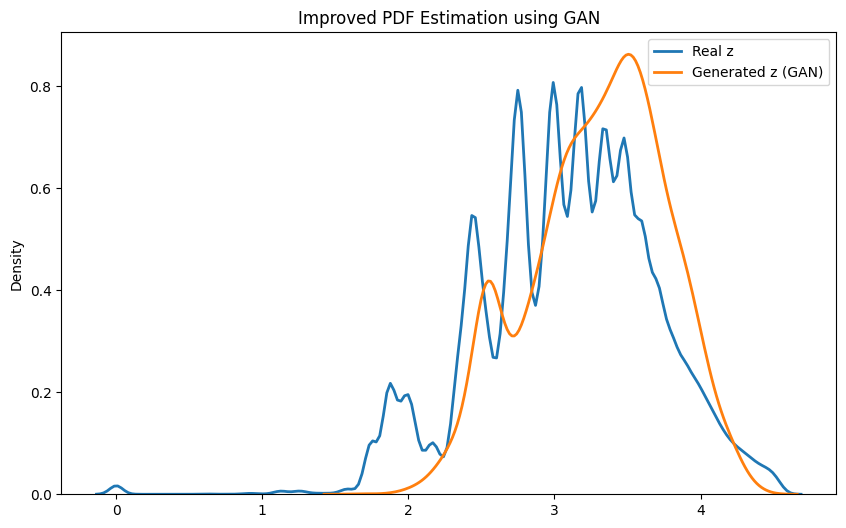

In [28]:
with torch.no_grad():
    noise = torch.randn(5000, 1)
    generated = G(noise).numpy()

generated_original = scaler.inverse_transform(generated)
real_original = scaler.inverse_transform(z_scaled)

plt.figure(figsize=(10,6))
sns.kdeplot(real_original.flatten(), label="Real z", linewidth=2)
sns.kdeplot(generated_original.flatten(), label="Generated z (GAN)", linewidth=2)
plt.legend()
plt.title("Improved PDF Estimation using GAN")
plt.show()

In [29]:
# Number of synthetic samples
num_samples = 20000

with torch.no_grad():
    noise = torch.randn(num_samples, 1)  # Noise ~ N(0,1)
    z_fake_scaled = G(noise).numpy()

# Convert back to original scale
z_fake = scaler.inverse_transform(z_fake_scaled)

print("Generated samples shape:", z_fake.shape)

Generated samples shape: (20000, 1)


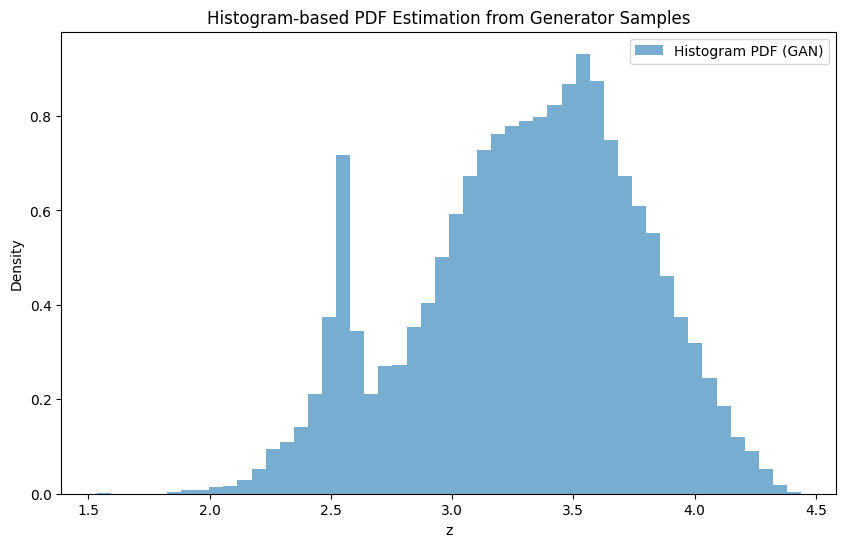

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(10,6))

plt.hist(z_fake.flatten(), bins=50, density=True, alpha=0.6, label="Histogram PDF (GAN)")

plt.title("Histogram-based PDF Estimation from Generator Samples")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()
plt.savefig("histogram_pdf.png")

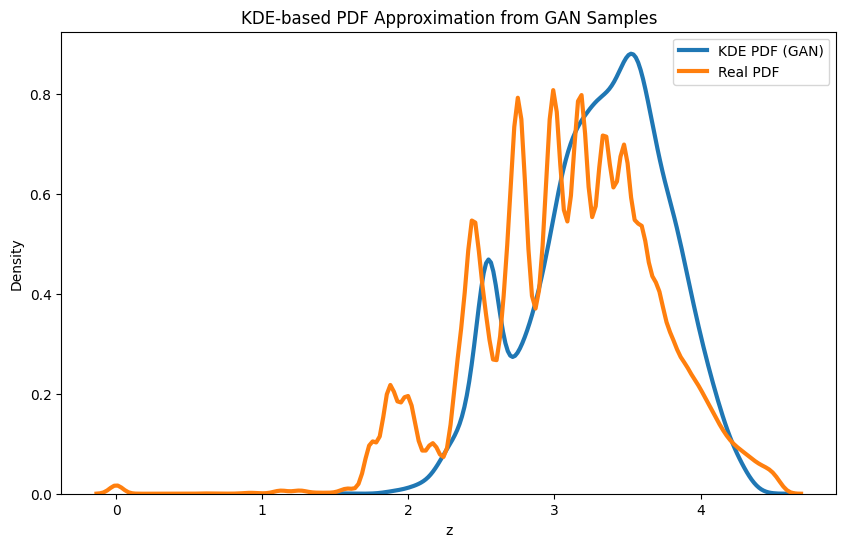

<Figure size 640x480 with 0 Axes>

In [33]:
import seaborn as sns

plt.figure(figsize=(10,6))

sns.kdeplot(z_fake.flatten(), linewidth=3, label="KDE PDF (GAN)")
sns.kdeplot(real_original.flatten(), linewidth=3, label="Real PDF")

plt.title("KDE-based PDF Approximation from GAN Samples")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()
plt.savefig("KDE_pdf.png")

In [32]:
print("Real Mean:", np.mean(real_original))
print("Fake Mean:", np.mean(z_fake))

print("Real Variance:", np.var(real_original))
print("Fake Variance:", np.var(z_fake))

Real Mean: 3.0853776534381243
Fake Mean: 3.3005035
Real Variance: 0.3575367274682747
Fake Variance: 0.21531118


In [36]:
print(r)
print(a_r)
print(b_r)

102303139
0.5
1.5
